## LIBRERIE UTILIZZATE


In [1]:
#manipolazione dei dati
import re #per usare i metodi regex
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

#tecniche di text mining per la pulizia 
import nltk
from nltk.corpus import stopwords  #rimozione delle stopword 
from nltk.tokenize import word_tokenize, RegexpTokenizer#tokenizzazione 
from nltk.stem import PorterStemmer #stemmming
from nltk.stem import WordNetLemmatizer #lemmatization
from nltk.tokenize import word_tokenize#tokenizzazione 
from nltk.probability import FreqDist

#apprendimento per gli algoritmi
import random 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#algoritmi
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,confusion_matrix,classification_report,f1_score,accuracy_score,precision_score,recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

#sovracampionamento tramite SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE

In [2]:
#IMPORTO I DATASET E NE CREO UNO UNICO 
df_1 = pd.read_csv("20210310-tweetitaly-holiday.csv") 
df_2 = pd.read_csv("20210310-tweetitaly-travel.csv")
df_3 = pd.read_csv("20210310-tweetitaly-trip.csv") 
df_4 = pd.read_csv("20210310-tweetitaly-visit.csv")  

df_5 = pd.merge(df_1,df_2, how ='outer')
df_6 = pd.merge(df_3,df_4, how='outer')

df_7 = pd.merge(df_5,df_6, how='outer')

In [3]:
#SALVO IL DATASET TOTALE 
df_7.to_csv('test_PY.csv')

## IMPORTO IL DATASET

In [4]:
df =pd.read_csv("test_etichettato.csv")#è stato etichettato completamente su Rstudio

## ANALISI DEL DATASET

In [5]:
#stampo informazioni del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2137 entries, 0 to 2136
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     2137 non-null   int64 
 1   ...1           2137 non-null   int64 
 2   text           2137 non-null   object
 3   favorited      2137 non-null   bool  
 4   favoriteCount  2137 non-null   int64 
 5   created        2137 non-null   object
 6   truncated      2137 non-null   bool  
 7   screenName     2137 non-null   object
 8   retweetCount   2137 non-null   int64 
 9   isRetweet      2137 non-null   bool  
 10  intention      2137 non-null   object
dtypes: bool(3), int64(4), object(4)
memory usage: 139.9+ KB


### L'etichettatura di ogni riga, quindi la creazione della colonna intention, è stata effettuata su R per comodità personale 

In [6]:
#rinomino la colonna per creare un indentatura interna al dataset
df.rename({'Unnamed: 0':'Indentation'},axis=1,inplace=True)
df.drop(['...1'], axis=1, inplace=True)#ripetizione dell'identatura delle rige 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2137 entries, 0 to 2136
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Indentation    2137 non-null   int64 
 1   text           2137 non-null   object
 2   favorited      2137 non-null   bool  
 3   favoriteCount  2137 non-null   int64 
 4   created        2137 non-null   object
 5   truncated      2137 non-null   bool  
 6   screenName     2137 non-null   object
 7   retweetCount   2137 non-null   int64 
 8   isRetweet      2137 non-null   bool  
 9   intention      2137 non-null   object
dtypes: bool(3), int64(3), object(4)
memory usage: 123.3+ KB


In [8]:
#Controllo se ci dovessero essere missing values nelle colonne 
df.isnull().sum()

Indentation      0
text             0
favorited        0
favoriteCount    0
created          0
truncated        0
screenName       0
retweetCount     0
isRetweet        0
intention        0
dtype: int64

In [9]:
#con la colonna dell'identatura e dell'intenzione controllo se il num delle istanze corrisponde al numero dell etichette inserite
x = df.drop(df.columns.difference(['Indentation']), axis=1).groupby(df.intention).count()
x

,Indentation
intention,
N,1977
Y,160


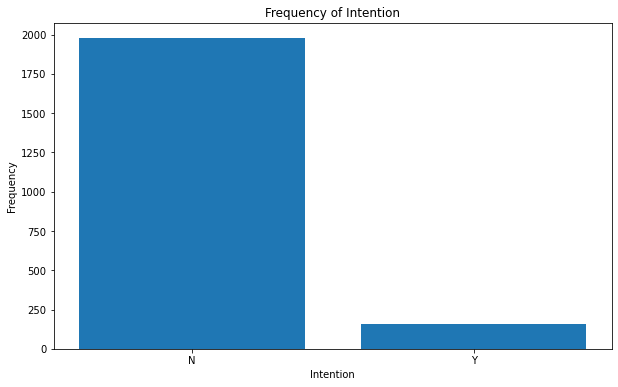

In [10]:
#BARPLOT
import collections
data = df['intention']
c = collections.Counter(data)
c = sorted(c.items())
intention_num= [i[0] for i in c]
freq = [i[1] for i in c]
plt.figure(figsize=(10,6))
plt.bar(intention_num, freq)
plt.title("Frequency of Intention")
plt.xlabel("Intention")
plt.ylabel("Frequency")
plt.show()

Possiamo affermare che il dataset è fortemente sbilanciato

## PULIZIA E TOKENIZZAZIONE

In [11]:
df['text'][0]

'.@Roma__Go @Turismoromaweb @Italia @discoveroma Street Performers in #Rome, #Italy.\r\r\r\n\r\r\r\n#Streets #streetphoto<U+0085> https://t.co/upVdb3H91s'

In [12]:
df['text'] = df['text'].astype(str).str.lower()#rendo tutto minuscolo la colonna del testo
df['text'] = df['text'].replace(r'http\S+', '', regex=True)#rimozione dei link 
df['text'] = df['text'].replace(r'<\S+', '', regex=True)#rimozione dell'eventuali emoji
print(df['text'][0])

.@roma__go @turismoromaweb @italia @discoveroma street performers in #rome, #italy.

#streets #streetphoto 


In [13]:
#nltk.download('stopwords') #serve per scaricare il dizionario delle stopwords
#attraverso nltk tokenizzo e rimuovo le stopword
z = RegexpTokenizer('\w+')
df['token']=df['text'].apply(z.tokenize)#con questo metodo si leva anche la punteggiatura

#rimozione delle stopwrds inglesi
sw = nltk.corpus.stopwords.words("english")
df['token'] = df['token'].apply(lambda x: [item for item in x if item not in sw])
df['token'] = df['token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

#controllo se tutto è andato a buon fine 
print(df['text'][0])
print(df['token'][0])

.@roma__go @turismoromaweb @italia @discoveroma street performers in #rome, #italy.

#streets #streetphoto 
roma__go turismoromaweb italia discoveroma street performers rome italy streets streetphoto


In [14]:
#stemming
df['token'] = df['token'].astype(str).str.lower()
porter = PorterStemmer()
df['token'] = df['token'].apply(porter.stem)
df['token'][1]

'london variant problem italy many holiday destinations little vaccinesoon protect holidaymak'

In [15]:
all_words = ' '.join([word for word in df['token'].str.replace('\d+','')])
words = nltk.word_tokenize(all_words)
freq = FreqDist(words)
freq

FreqDist({'italy': 1317, 'visit': 470, 'trip': 435, 'travel': 424, 'holiday': 240, 'itali': 196, 'year': 106, 'first': 99, 'like': 90, 'iraq': 89, ...})

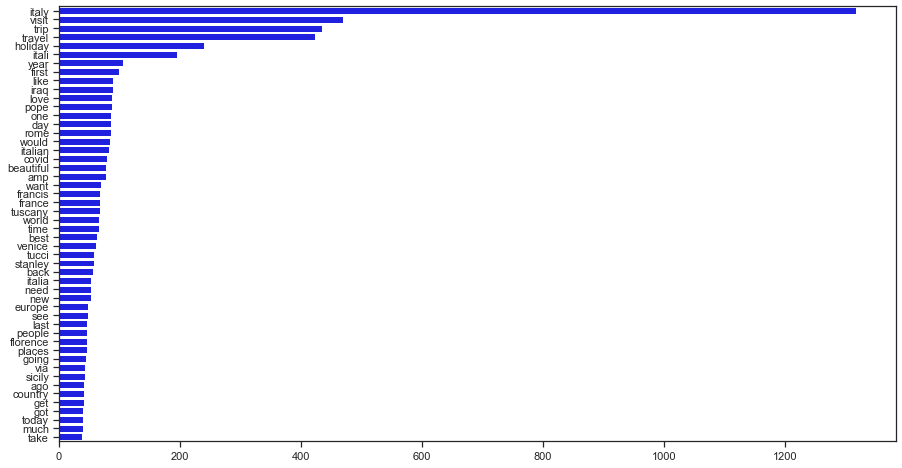

In [16]:
#grafico delle frequenze delle parole
top_10 = freq.most_common(50)
# Create pandas series to make plotting easier
fdist = pd.Series(dict(top_10))

sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="ticks")
sns.barplot(y=fdist.index, x=fdist.values, color='blue');

# VETTORIZZAZIONE E CREAZIONE DEL CORPUS

In [17]:
col = df['token']
corpus = col.values.tolist()
print(corpus[1])

london variant problem italy many holiday destinations little vaccinesoon protect holidaymak


In [18]:
tf_idf = Pipeline([('cv',CountVectorizer()), ('tfidf_transformer',TfidfTransformer(smooth_idf=True,use_idf=True))])
x = tf_idf.fit_transform(corpus).toarray()
print(x.shape)

(2137, 6322)


In [19]:
df['intention'] = df['intention'].replace('N', 0)
df['intention'] = df['intention'].replace('Y', 1)
y = df['intention']
y

0       0
1       0
2       0
3       1
4       0
       ..
2132    0
2133    0
2134    0
2135    0
2136    0
Name: intention, Length: 2137, dtype: int64

# APPRENDIMENTO

In [20]:
random.seed(123)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
print('Istanze per il Training:',x_train.shape)
print('Istanze per il Testing:',x_test.shape)

Istanze per il Training: (1709, 6322)
Istanze per il Testing: (428, 6322)


In [21]:
# Random Forest
rf= RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(x_train, y_train)
rf_score = rf.score(x_train, y_train)

# Linear Support Vector Machine
svm = SVC(kernel='linear', probability=True)
svm.fit(x_train, y_train)
svm_score = svm.score(x_train, y_train)

# Naive Bayes
nb = GaussianNB()
nb.fit(x_train,y_train)
nb_score = nb.score(x_train,y_train)

# Decision Tree
d_tree = DecisionTreeClassifier(criterion="entropy", max_depth=3)
d_tree = d_tree.fit(x_train, y_train)
d_tree_score = d_tree.score(x_train, y_train)

### Confronto dei Valori nel Training

In [20]:
accuracy = []
algorithm = ['Random Forest','Support Vector Machine','Naive Bayes','DecisioneTree']
accuracy.append(rf_score)
accuracy.append(svm_score)
accuracy.append(nb_score)
accuracy.append(d_tree_score)
score_comparisons = pd.DataFrame(algorithm, columns = ['Algorithm'])
score_comparisons['Accuracy of Training Dataset'] = accuracy
score_comparisons

,Algorithm,Accuracy of Training Dataset
0,Random Forest,0.999415
1,Support Vector Machine,0.970743
2,Naive Bayes,0.991808
3,DecisioneTree,0.937390


# Esecuzione Algoritmi

In [22]:
print('Istanze per il testing:')
y_test.value_counts()

Istanze per il testing:


0    397
1     31
Name: intention, dtype: int64

## Random Forest

In [25]:
rf_pred = rf.predict(x_test)
# Accuracy finale
print('Accuracy of Testing:',accuracy_score(y_test,rf_pred))

Accuracy of Testing: 0.927570093457944


In [30]:
#creazione della variabile contente la matrice di confusione 
m_f= confusion_matrix(y_test,rf_pred)

#mostro i valori presenti nella matrice 
print('\nTrue Positives(TP) = ',m_f[0,0])
print('\nTrue Negatives(TN) = ',m_f[1,1])
print('\nFalse Positives(FP) = ',m_f[0,1])
print('\nFalse Negatives(FN) = ', m_f[1,0])

# visualizzazione della matrice di confusione 
cm= pd.DataFrame(data=m_f, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
cm


True Positives(TP) =  395

True Negatives(TN) =  2

False Positives(FP) =  2

False Negatives(FN) =  29


,Actual Positive,Actual Negative
Predict Positive,395,2
Predict Negative,29,2


In [31]:
#valori delle altre metriche 
class_rf = classification_report(y_test, rf_pred)
#print("PRINT ", type(class_rf))

#print(classification_report(y_test, prediction_forest))
# print classification accuracy
TP = m_f[0,0]
TN = m_f[1,1]
FP = m_f[0,1]
FN = m_f[1,0]
print('Other Metrics:')
print('- TP:',TP,",",'TN:',TN,",",'FP:',FP,",",'FN:', FN)
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('- Classification accuracy: {0:0.4f}'.format(classification_accuracy))
# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('- Classification error: {0:0.4f}'.format(classification_error))
# print precision score
precision = TP / float(TP + FP)
print('- Precision: {0:0.4f}'.format(precision))
# print recall
recall = TP / float(TP + FN)
print('- Recall or Sensitivity: {0:0.4f}'.format(recall))
# punteggio veri positivi
true_positive_rate = TP / float(TP + FN)
print('- True Positive Rate: {0:0.4f}'.format(true_positive_rate))
# punteggio falsi positivi
false_positive_rate = FP / float(FP + TN)
print('- False Positive Rate: {0:0.4f}'.format(false_positive_rate))
# print specifity
specificity = TN / (TN + FP)
print('- Specificity: {0:0.4f}'.format(specificity))

Other Metrics:
- TP: 395 , TN: 2 , FP: 2 , FN: 29
- Classification accuracy: 0.9276
- Classification error: 0.0724
- Precision: 0.9950
- Recall or Sensitivity: 0.9316
- True Positive Rate: 0.9316
- False Positive Rate: 0.5000
- Specificity: 0.5000


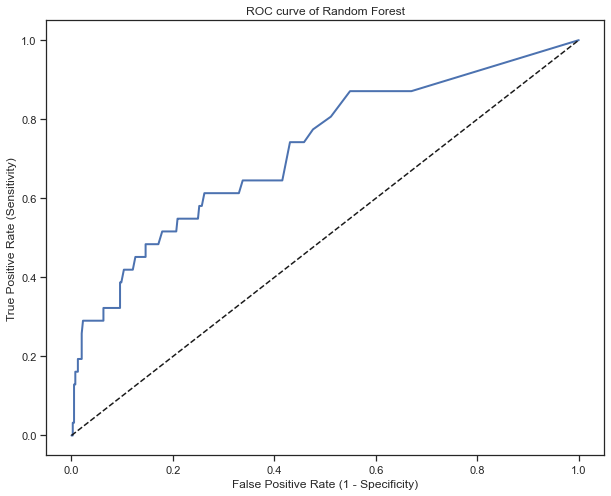

In [32]:
random.seed(124)
#Curva ROC per vedere l'efficacia del classificatore 
rf_roc = roc_auc_score(y_test, rf.predict(x_test))
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf.predict_proba(x_test)[:, 1])
plt.figure(figsize=(10,8))
plt.plot(fpr_rf, tpr_rf, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve of Random Forest')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

## Support Vector Machine

In [21]:
svm_pred = svm.predict(x_test)
print('Accuracy finale:',accuracy_score(y_test,svm_pred))

Accuracy finale: 0.927570093457944


In [33]:
random.seed(123)
#creazione della variabile contente la matrice di confusione 
m_svm= confusion_matrix(y_test,svm_pred)

#mostro i valori presenti nella matrice 
print('\nTrue Positives(TP) = ',m_svm[0,0])
print('\nTrue Negatives(TN) = ',m_svm[1,1])
print('\nFalse Positives(FP) = ',m_svm[0,1])
print('\nFalse Negatives(FN) = ', m_svm[1,0])

# visualizzazione della matrice di confusione 
cm_svm= pd.DataFrame(data=m_svm, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
cm_svm


True Positives(TP) =  393

True Negatives(TN) =  4

False Positives(FP) =  4

False Negatives(FN) =  27


,Actual Positive,Actual Negative
Predict Positive,393,4
Predict Negative,27,4


In [34]:
random.seed(123)
#valori delle altre metriche 
class_svm = classification_report(y_test, svm_pred)
#print("PRINT ", type(class_rf))

#print(classification_report(y_test, prediction_forest))
# print classification accuracy
TP = m_svm[0,0]
TN = m_svm[1,1]
FP = m_svm[0,1]
FN = m_svm[1,0]
print('Other Metrics:')
print('- TP:',TP,",",'TN:',TN,",",'FP:',FP,",",'FN:', FN)
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('- Classification accuracy: {0:0.4f}'.format(classification_accuracy))
# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('- Classification error: {0:0.4f}'.format(classification_error))
# print precision score
precision = TP / float(TP + FP)
print('- Precision: {0:0.4f}'.format(precision))
# print recall
recall = TP / float(TP + FN)
print('- Recall or Sensitivity: {0:0.4f}'.format(recall))
# punteggio veri positivi
true_positive_rate = TP / float(TP + FN)
print('- True Positive Rate: {0:0.4f}'.format(true_positive_rate))
# punteggio falsi positivi
false_positive_rate = FP / float(FP + TN)
print('- False Positive Rate: {0:0.4f}'.format(false_positive_rate))
# print specifity
specificity = TN / (TN + FP)
print('- Specificity: {0:0.4f}'.format(specificity))

Other Metrics:
- TP: 393 , TN: 4 , FP: 4 , FN: 27
- Classification accuracy: 0.9276
- Classification error: 0.0724
- Precision: 0.9899
- Recall or Sensitivity: 0.9357
- True Positive Rate: 0.9357
- False Positive Rate: 0.5000
- Specificity: 0.5000


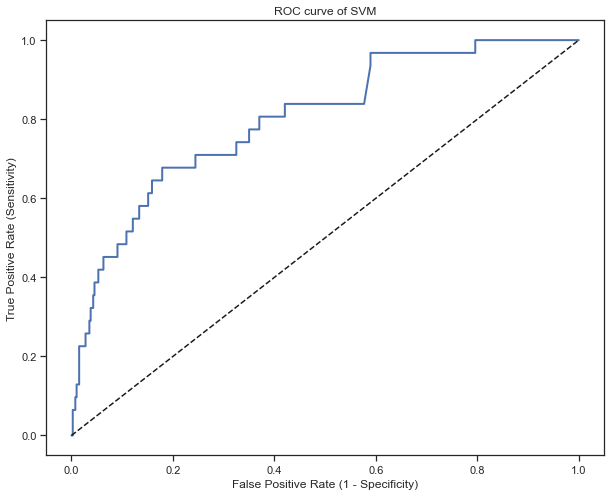

In [35]:
#Curva ROC per vedere l'efficacia del classificatore 
svm_roc = roc_auc_score(y_test, svm.predict(x_test))
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm.predict_proba(x_test)[:, 1])
plt.figure(figsize=(10,8))
plt.plot(fpr_svm, tpr_svm, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve of SVM')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

## Naive Bayes

In [40]:
nb_pred = nb.predict(x_test)
print('Accuracy finale:',accuracy_score(y_test,nb_pred))

Accuracy finale: 0.897196261682243


In [41]:
#creazione della variabile contente la matrice di confusione 
m_nb = confusion_matrix(y_test,nb_pred)

#mostro i valori presenti nella matrice 
print('\nTrue Positives(TP) = ',m_nb[0,0])
print('\nTrue Negatives(TN) = ',m_nb[1,1])
print('\nFalse Positives(FP) = ',m_nb[0,1])
print('\nFalse Negatives(FN) = ', m_nb[1,0])

# visualizzazione della matrice di confusione 
cm_nb = pd.DataFrame(data=m_nb, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
cm_nb


True Positives(TP) =  377

True Negatives(TN) =  7

False Positives(FP) =  20

False Negatives(FN) =  24


,Actual Positive,Actual Negative
Predict Positive,377,20
Predict Negative,24,7


In [78]:
#valori delle altre metriche 
class_nb = classification_report(y_test, nb_pred)
#print("PRINT ", type(class_rf))

#print(classification_report(y_test, prediction_forest))
# print classification accuracy
TP = m_nb[0,0]
TN = m_nb[1,1]
FP = m_nb[0,1]
FN = m_nb[1,0]
print('Other Metrics:')
print('- TP:',TP,",",'TN:',TN,",",'FP:',FP,",",'FN:', FN)
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('- Classification accuracy: {0:0.4f}'.format(classification_accuracy))
# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('- Classification error: {0:0.4f}'.format(classification_error))
# print precision score
precision = TP / float(TP + FP)
print('- Precision: {0:0.4f}'.format(precision))
# print recall
recall = TP / float(TP + FN)
print('- Recall or Sensitivity: {0:0.4f}'.format(recall))
# punteggio veri positivi
true_positive_rate = TP / float(TP + FN)
print('- True Positive Rate: {0:0.4f}'.format(true_positive_rate))
# punteggio falsi positivi
false_positive_rate = FP / float(FP + TN)
print('- False Positive Rate: {0:0.4f}'.format(false_positive_rate))
# print specifity
specificity = TN / (TN + FP)
print('- Specificity: {0:0.4f}'.format(specificity))

Other Metrics:
- TP: 377 , TN: 7 , FP: 20 , FN: 24
- Classification accuracy: 0.8972
- Classification error: 0.1028
- Precision: 0.9496
- Recall or Sensitivity: 0.9401
- True Positive Rate: 0.9401
- False Positive Rate: 0.7407
- Specificity: 0.2593


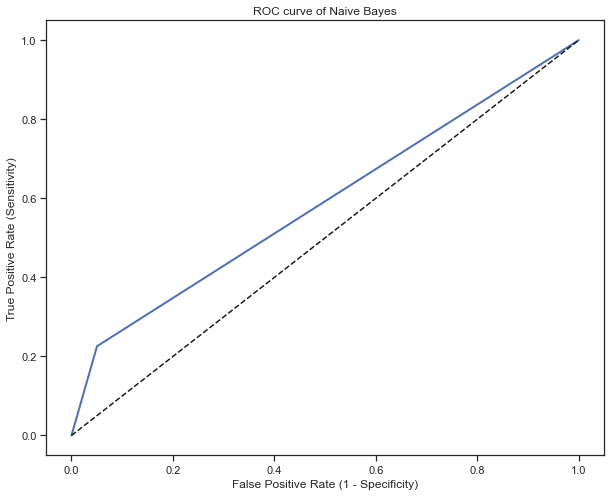

In [79]:
#Curva ROC per vedere l'efficacia del classificatore 
nb_roc = roc_auc_score(y_test, nb.predict(x_test))
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, nb.predict_proba(x_test)[:, 1])
plt.figure(figsize=(10,8))
plt.plot(fpr_nb, tpr_nb, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve of Naive Bayes')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

## Decision Tree

In [22]:
d_tree_pred = d_tree.predict(x_test)
# Accuracy finale
print('Accuracy finale:',accuracy_score(y_test,d_tree_pred))

Accuracy finale: 0.9252336448598131


In [43]:
#creazione della variabile contente la matrice di confusione 
m_dtree= confusion_matrix(y_test,d_tree_pred)

#mostro i valori presenti nella matrice 
print('\nTrue Positives(TP) = ',m_dtree[0,0])
print('\nTrue Negatives(TN) = ',m_dtree[1,1])
print('\nFalse Positives(FP) = ',m_dtree[0,1])
print('\nFalse Negatives(FN) = ',m_dtree[1,0])

# visualizzazione della matrice di confusione 
cm_dtree= pd.DataFrame(data=m_dtree, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
cm_dtree


True Positives(TP) =  394

True Negatives(TN) =  2

False Positives(FP) =  3

False Negatives(FN) =  29


,Actual Positive,Actual Negative
Predict Positive,394,3
Predict Negative,29,2


In [44]:
#valori delle altre metriche 
class_dtree = classification_report(y_test, d_tree_pred)
#print("PRINT ", type(class_rf))

#print(classification_report(y_test, prediction_forest))
# print classification accuracy
TP = m_dtree[0,0]
TN = m_dtree[1,1]
FP = m_dtree[0,1]
FN = m_dtree[1,0]
print('Other Metrics:')
print('- TP:',TP,",",'TN:',TN,",",'FP:',FP,",",'FN:', FN)
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('- Classification accuracy: {0:0.4f}'.format(classification_accuracy))
# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('- Classification error: {0:0.4f}'.format(classification_error))
# print precision score
precision = TP / float(TP + FP)
print('- Precision: {0:0.4f}'.format(precision))
# print recall
recall = TP / float(TP + FN)
print('- Recall or Sensitivity: {0:0.4f}'.format(recall))
# punteggio veri positivi
true_positive_rate = TP / float(TP + FN)
print('- True Positive Rate: {0:0.4f}'.format(true_positive_rate))
# punteggio falsi positivi
false_positive_rate = FP / float(FP + TN)
print('- False Positive Rate: {0:0.4f}'.format(false_positive_rate))
# print specifity
specificity = TN / (TN + FP)
print('- Specificity: {0:0.4f}'.format(specificity))

Other Metrics:
- TP: 394 , TN: 2 , FP: 3 , FN: 29
- Classification accuracy: 0.9252
- Classification error: 0.0748
- Precision: 0.9924
- Recall or Sensitivity: 0.9314
- True Positive Rate: 0.9314
- False Positive Rate: 0.6000
- Specificity: 0.4000


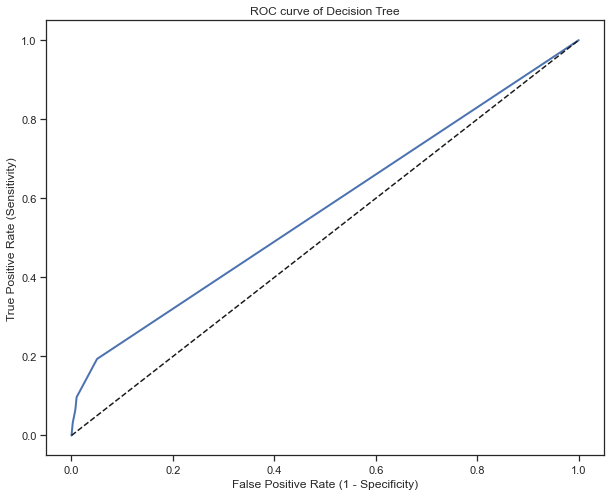

In [23]:
#Curva ROC per vedere l'efficacia del classificatore 
dtree_roc = roc_auc_score(y_test, d_tree.predict(x_test))
fpr_dtree, tpr_dtree, thresholds_dtree = roc_curve(y_test,d_tree.predict_proba(x_test)[:, 1])
plt.figure(figsize=(10,8))
plt.plot(fpr_dtree, tpr_dtree, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve of Decision Tree')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

## Confronto delle ROC Curve

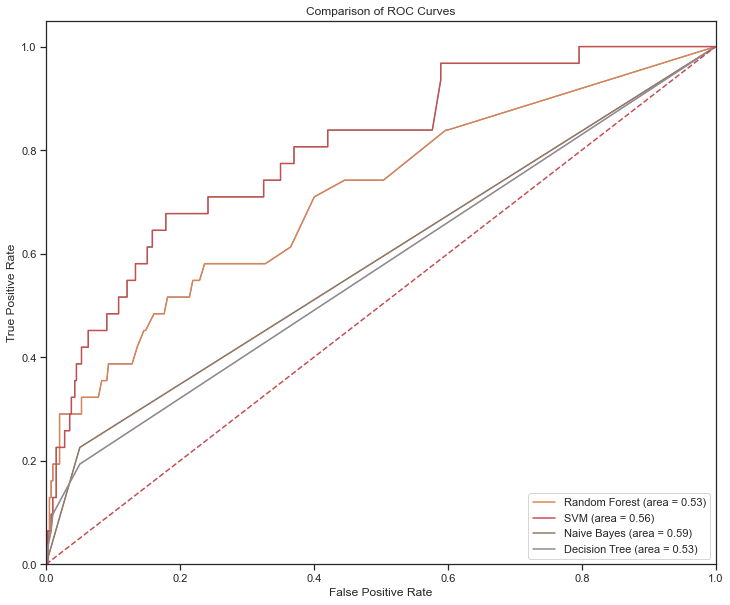

In [84]:
plt.figure(figsize=(12,10))
plt.plot(fpr_rf, tpr_rf, linewidth=1)
plt.plot(fpr_rf, tpr_rf, label='Random Forest (area = %0.2f)' % rf_roc)
plt.plot(fpr_svm, tpr_svm, linewidth=1)
plt.plot(fpr_svm, tpr_svm, label='SVM (area = %0.2f)' % svm_roc)
plt.plot(fpr_nb, tpr_nb, linewidth=1)
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (area = %0.2f)' % nb_roc)
plt.plot(fpr_dtree, tpr_dtree, linewidth=1)
plt.plot(fpr_dtree, tpr_dtree, label='Decision Tree (area = %0.2f)' % dtree_roc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.rcParams['font.size'] = 10
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc="lower right")
plt.show()

Possiamo quindi affermare che il miglior modello è quello dell'algoritmo SVM

# BILANCIAMENTO

## SMOTE

In [25]:
subset = df 
subset

,Indentation,text,favorited,favoriteCount,created,truncated,screenName,retweetCount,isRetweet,intention,token
0,1,.@roma__go @turismoromaweb @italia @discoverom...,False,0,2021-03-10,True,GiaHomemade,0,False,0,roma__go turismoromaweb italia discoveroma str...
1,2,london variant problem in italy and many holid...,False,0,2021-03-10,False,colinwarburton7,0,False,0,london variant problem italy many holiday dest...
2,3,looking for a fixed based cycling holiday in i...,False,0,2021-03-10,True,hookedoncycling,0,False,0,looking fixed based cycling holiday italy marc...
3,4,booked a holiday for june 2022! #rome #sorrent...,False,1,2021-03-10,True,ChrisDavidStone,0,False,1,booked holiday june 2022 rome sorrento almafi ...
4,5,@natiafc me and my brother went on holiday to ...,False,1,2021-03-10,True,lethal_linesh,0,False,0,natiafc brother went holiday italy watched gam...
...,...,...,...,...,...,...,...,...,...,...,...
2132,2133,rt @worldwidettips: @trjforbloggers we follow ...,False,0,2021-03-05,False,TRJForBloggers,1,True,0,worldwidettips trjforbloggers follow back retu...
2133,2134,rt @worldwidettips: @trjforbloggers we follow ...,False,0,2021-03-05,False,TRJForBloggers,1,True,0,worldwidettips trjforbloggers follow back like...
2134,2135,"@terrinakamura terri, if you can imagine it......",False,0,2021-03-05,True,JessanDunnOtis,0,False,0,terrinakamura terri imagine hence amp achievab...
2135,2136,whenever i go back italy gonna visit this fella,False,1,2021-03-05,False,interaubis,0,False,0,whenever back italy gonna visit fella


In [26]:
# N=0 / Y=1
print(Counter(subset.intention))

# SMOTE algorithm (without string variables)
smote = SMOTE(random_state=0)
twitter_balanced, label_balanced = smote.fit_resample(x, subset.intention)
print(len(twitter_balanced))
print(len(label_balanced))

Counter({0: 1977, 1: 160})
3954
3954


In [27]:
print(Counter(label_balanced))

Counter({0: 1977, 1: 1977})


# Apprendimento con DB Bilanciato

In [28]:
random.seed(1234)
X_train, X_test, Y_train, Y_test = train_test_split(twitter_balanced,
                        label_balanced, test_size=0.2, random_state=0)

print('Istanze per il Training:', X_train.shape)
print('Istanze per il Testing:', X_test.shape)
#print('Y_train shape', Y_train.shape)
#print('Y_test shape', Y_test.shape)

Istanze per il Training: (3163, 6322)
Istanze per il Testing: (791, 6322)


In [29]:
# Random Forest
rf_b= RandomForestClassifier(n_estimators=500, random_state=42)
rf_b.fit(X_train, Y_train)
rf_score_b = rf_b.score(X_train, Y_train)

# Linear Support Vector Machine
svm_b = SVC(kernel='linear', probability=True)
svm_b.fit(X_train, Y_train)
svm_score_b = svm_b.score(X_train, Y_train)

# Naive Bayes
nb_b = GaussianNB()
nb_b.fit(X_train,Y_train)
nb_score_b = nb_b.score(X_train,Y_train)

# Decision Tree
d_tree_b = DecisionTreeClassifier(criterion="entropy", max_depth=3)
d_tree_b = d_tree_b.fit(X_train, Y_train)
d_tree_score_b = d_tree_b.score(X_train, Y_train)

In [30]:
accuracy_b = []
algorithm_b = ['Random Forest','Support Vector Machine','Naive Bayes','DecisioneTree']
accuracy_b.append(rf_score_b)
accuracy_b.append(svm_score_b)
accuracy_b.append(nb_score_b)
accuracy_b.append(d_tree_score_b)
score_comparisons_b = pd.DataFrame(algorithm_b, columns = ['Balanced Algorithm'])
score_comparisons_b['Accuracy of Training Dataset'] = accuracy_b
score_comparisons_b

,Balanced Algorithm,Accuracy of Training Dataset
0,Random Forest,0.999684
1,Support Vector Machine,0.995574
2,Naive Bayes,0.995574
3,DecisioneTree,0.790389


# Esecuzione Algoritmi

In [36]:
print('Istanze per il Testing:')
Y_test.value_counts()

Istanze per il Testing:


0    412
1    379
Name: intention, dtype: int64

## Balanced Random Forest

In [37]:
rf_b_pred = rf_b.predict(X_test)
# Accuracy finale
print('Accuracy of Testing:',accuracy_score(Y_test,rf_b_pred))

Accuracy of Testing: 0.9911504424778761


In [38]:
#creazione della variabile contente la matrice di confusione 
m_f_b= confusion_matrix(Y_test,rf_b_pred)

#mostro i valori presenti nella matrice 
print('\nTrue Positives(TP) = ',m_f_b[0,0])
print('\nTrue Negatives(TN) = ',m_f_b[1,1])
print('\nFalse Positives(FP) = ',m_f_b[0,1])
print('\nFalse Negatives(FN) = ', m_f_b[1,0])

# visualizzazione della matrice di confusione 
cm_b= pd.DataFrame(data=m_f_b, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
cm_b


True Positives(TP) =  409

True Negatives(TN) =  375

False Positives(FP) =  3

False Negatives(FN) =  4


,Actual Positive,Actual Negative
Predict Positive,409,3
Predict Negative,4,375


In [39]:
#valori delle altre metriche 
class_rf_b = classification_report(Y_test, rf_b_pred)
#print("PRINT ", type(class_rf))

#print(classification_report(y_test, prediction_forest))
# print classification accuracy
TP = m_f_b[0,0]
TN = m_f_b[1,1]
FP = m_f_b[0,1]
FN = m_f_b[1,0]
print('Other Metrics:')
print('- TP:',TP,",",'TN:',TN,",",'FP:',FP,",",'FN:', FN)
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('- Classification accuracy: {0:0.4f}'.format(classification_accuracy))
# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('- Classification error: {0:0.4f}'.format(classification_error))
# print precision score
precision = TP / float(TP + FP)
print('- Precision: {0:0.4f}'.format(precision))
# print recall
recall = TP / float(TP + FN)
print('- Recall or Sensitivity: {0:0.4f}'.format(recall))
# punteggio veri positivi
true_positive_rate = TP / float(TP + FN)
print('- True Positive Rate: {0:0.4f}'.format(true_positive_rate))
# punteggio falsi positivi
false_positive_rate = FP / float(FP + TN)
print('- False Positive Rate: {0:0.4f}'.format(false_positive_rate))
# print specifity
specificity = TN / (TN + FP)
print('- Specificity: {0:0.4f}'.format(specificity))

Other Metrics:
- TP: 409 , TN: 375 , FP: 3 , FN: 4
- Classification accuracy: 0.9912
- Classification error: 0.0088
- Precision: 0.9927
- Recall or Sensitivity: 0.9903
- True Positive Rate: 0.9903
- False Positive Rate: 0.0079
- Specificity: 0.9921


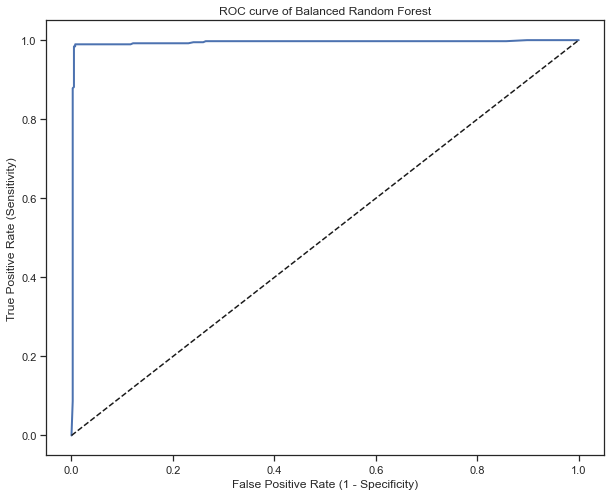

In [40]:
#Curva ROC per vedere l'efficacia del classificatore 
rf_roc_b = roc_auc_score(Y_test, rf_b.predict(X_test))
fpr_rf_b, tpr_rf_b, thresholds_rf_b = roc_curve(Y_test, rf_b.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10,8))
plt.plot(fpr_rf_b, tpr_rf_b,linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve of Balanced Random Forest')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

## Balanced SVM

In [41]:
svm_pred_b = svm_b.predict(X_test)
print('Accuracy finale:',accuracy_score(Y_test,svm_pred_b))

Accuracy finale: 0.9835651074589128


In [42]:
#creazione della variabile contente la matrice di confusione 
m_svm_b = confusion_matrix(Y_test,svm_pred_b)

#mostro i valori presenti nella matrice 
print('\nTrue Positives(TP) = ',m_svm_b[0,0])
print('\nTrue Negatives(TN) = ',m_svm_b[1,1])
print('\nFalse Positives(FP) = ',m_svm_b[0,1])
print('\nFalse Negatives(FN) = ', m_svm_b[1,0])

# visualizzazione della matrice di confusione 
cm_svm_b= pd.DataFrame(data=m_svm_b, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
cm_svm_b


True Positives(TP) =  401

True Negatives(TN) =  377

False Positives(FP) =  11

False Negatives(FN) =  2


,Actual Positive,Actual Negative
Predict Positive,401,11
Predict Negative,2,377


In [43]:
#valori delle altre metriche 
class_svm_b = classification_report(Y_test, svm_pred_b)
#print("PRINT ", type(class_rf))

#print(classification_report(y_test, prediction_forest))
# print classification accuracy
TP = m_svm_b[0,0]
TN = m_svm_b[1,1]
FP = m_svm_b[0,1]
FN = m_svm_b[1,0]
print('Other Metrics:')
print('- TP:',TP,",",'TN:',TN,",",'FP:',FP,",",'FN:', FN)
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('- Classification accuracy: {0:0.4f}'.format(classification_accuracy))
# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('- Classification error: {0:0.4f}'.format(classification_error))
# print precision score
precision = TP / float(TP + FP)
print('- Precision: {0:0.4f}'.format(precision))
# print recall
recall = TP / float(TP + FN)
print('- Recall or Sensitivity: {0:0.4f}'.format(recall))
# punteggio veri positivi
true_positive_rate = TP / float(TP + FN)
print('- True Positive Rate: {0:0.4f}'.format(true_positive_rate))
# punteggio falsi positivi
false_positive_rate = FP / float(FP + TN)
print('- False Positive Rate: {0:0.4f}'.format(false_positive_rate))
# print specifity
specificity = TN / (TN + FP)
print('- Specificity: {0:0.4f}'.format(specificity))

Other Metrics:
- TP: 401 , TN: 377 , FP: 11 , FN: 2
- Classification accuracy: 0.9836
- Classification error: 0.0164
- Precision: 0.9733
- Recall or Sensitivity: 0.9950
- True Positive Rate: 0.9950
- False Positive Rate: 0.0284
- Specificity: 0.9716


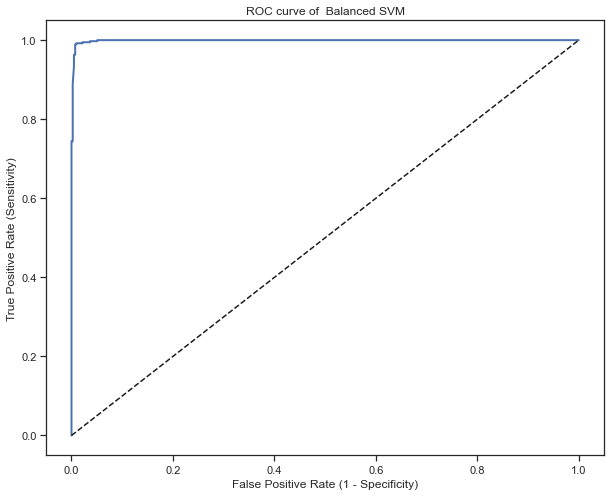

In [44]:
#Curva ROC per vedere l'efficacia del classificatore 
svm_roc_b = roc_auc_score(Y_test, svm_b.predict(X_test))
fpr_svm_b, tpr_svm_b, thresholds_svm_b = roc_curve(Y_test, svm_b.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10,8))
plt.plot(fpr_svm_b, tpr_svm_b, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve of  Balanced SVM')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

## Balanced Naive Bayes

In [45]:
nb_pred_b = nb_b.predict(X_test)
print('Accuracy finale:',accuracy_score(Y_test,nb_pred_b))

Accuracy finale: 0.9671302149178256


In [46]:
#creazione della variabile contente la matrice di confusione 
m_nb_b = confusion_matrix(Y_test,nb_pred_b)

#mostro i valori presenti nella matrice 
print('\nTrue Positives(TP) = ',m_nb_b[0,0])
print('\nTrue Negatives(TN) = ',m_nb_b[1,1])
print('\nFalse Positives(FP) = ',m_nb_b[0,1])
print('\nFalse Negatives(FN) = ', m_nb_b[1,0])

# visualizzazione della matrice di confusione 
cm_nb_b = pd.DataFrame(data=m_nb_b, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
cm_nb_b


True Positives(TP) =  386

True Negatives(TN) =  379

False Positives(FP) =  26

False Negatives(FN) =  0


,Actual Positive,Actual Negative
Predict Positive,386,26
Predict Negative,0,379


In [47]:
#valori delle altre metriche 
class_nb_b = classification_report(Y_test, nb_pred_b)
#print("PRINT ", type(class_rf))

#print(classification_report(y_test, prediction_forest))
# print classification accuracy
TP = m_nb_b[0,0]
TN = m_nb_b[1,1]
FP = m_nb_b[0,1]
FN = m_nb_b[1,0]
print('Other Metrics:')
print('- TP:',TP,",",'TN:',TN,",",'FP:',FP,",",'FN:', FN)
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('- Classification accuracy: {0:0.4f}'.format(classification_accuracy))
# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('- Classification error: {0:0.4f}'.format(classification_error))
# print precision score
precision = TP / float(TP + FP)
print('- Precision: {0:0.4f}'.format(precision))
# print recall
recall = TP / float(TP + FN)
print('- Recall or Sensitivity: {0:0.4f}'.format(recall))
# punteggio veri positivi
true_positive_rate = TP / float(TP + FN)
print('- True Positive Rate: {0:0.4f}'.format(true_positive_rate))
# punteggio falsi positivi
false_positive_rate = FP / float(FP + TN)
print('- False Positive Rate: {0:0.4f}'.format(false_positive_rate))
# print specifity
specificity = TN / (TN + FP)
print('- Specificity: {0:0.4f}'.format(specificity))

Other Metrics:
- TP: 386 , TN: 379 , FP: 26 , FN: 0
- Classification accuracy: 0.9671
- Classification error: 0.0329
- Precision: 0.9369
- Recall or Sensitivity: 1.0000
- True Positive Rate: 1.0000
- False Positive Rate: 0.0642
- Specificity: 0.9358


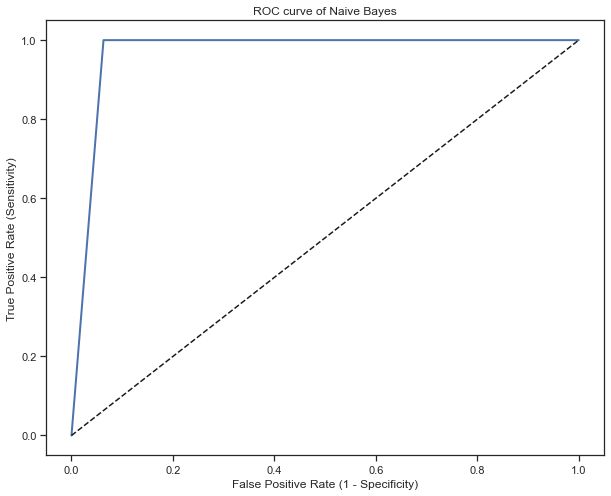

In [48]:
nb_roc_b = roc_auc_score(Y_test, nb_b.predict(X_test))
fpr_nb_b, tpr_nb_b, thresholds_nb_b = roc_curve(Y_test, nb_b.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10,8))
plt.plot(fpr_nb_b, tpr_nb_b, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve of Naive Bayes')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

## Balanced Decision Tree

In [49]:
d_tree_pred_b = d_tree_b.predict(X_test)
print('Accuracy finale:',accuracy_score(Y_test,d_tree_pred_b))

Accuracy finale: 0.8103666245259166


In [50]:
#creazione della variabile contente la matrice di confusione 
m_dtree_b= confusion_matrix(Y_test,d_tree_pred_b)

#mostro i valori presenti nella matrice 
print('\nTrue Positives(TP) = ',m_dtree_b[0,0])
print('\nTrue Negatives(TN) = ',m_dtree_b[1,1])
print('\nFalse Positives(FP) = ',m_dtree_b[0,1])
print('\nFalse Negatives(FN) = ',m_dtree_b[1,0])

# visualizzazione della matrice di confusione 
cm_dtree_b= pd.DataFrame(data=m_dtree_b, columns=['Actual Positive', 'Actual Negative'], 
                                 index=['Predict Positive', 'Predict Negative'])
cm_dtree_b


True Positives(TP) =  304

True Negatives(TN) =  337

False Positives(FP) =  108

False Negatives(FN) =  42


,Actual Positive,Actual Negative
Predict Positive,304,108
Predict Negative,42,337


In [51]:
#valori delle altre metriche 
class_dtree_b = classification_report(Y_test, d_tree_pred_b)
#print("PRINT ", type(class_rf))

#print(classification_report(y_test, prediction_forest))
# print classification accuracy
TP = m_dtree_b[0,0]
TN = m_dtree_b[1,1]
FP = m_dtree_b[0,1]
FN = m_dtree_b[1,0]
print('Other Metrics:')
print('- TP:',TP,",",'TN:',TN,",",'FP:',FP,",",'FN:', FN)
classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)
print('- Classification accuracy: {0:0.4f}'.format(classification_accuracy))
# print classification error
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print('- Classification error: {0:0.4f}'.format(classification_error))
# print precision score
precision = TP / float(TP + FP)
print('- Precision: {0:0.4f}'.format(precision))
# print recall
recall = TP / float(TP + FN)
print('- Recall or Sensitivity: {0:0.4f}'.format(recall))
# punteggio veri positivi
true_positive_rate = TP / float(TP + FN)
print('- True Positive Rate: {0:0.4f}'.format(true_positive_rate))
# punteggio falsi positivi
false_positive_rate = FP / float(FP + TN)
print('- False Positive Rate: {0:0.4f}'.format(false_positive_rate))
# print specifity
specificity = TN / (TN + FP)
print('- Specificity: {0:0.4f}'.format(specificity))

Other Metrics:
- TP: 304 , TN: 337 , FP: 108 , FN: 42
- Classification accuracy: 0.8104
- Classification error: 0.1896
- Precision: 0.7379
- Recall or Sensitivity: 0.8786
- True Positive Rate: 0.8786
- False Positive Rate: 0.2427
- Specificity: 0.7573


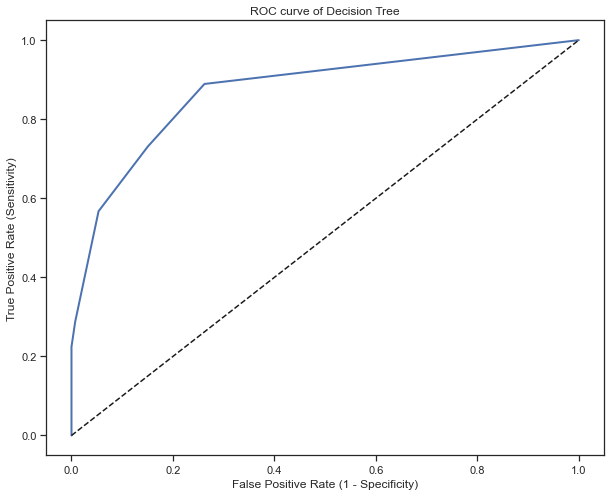

In [52]:
#Curva ROC per vedere l'efficacia del classificatore 
dtree_roc_b = roc_auc_score(Y_test, d_tree_b.predict(X_test))
fpr_dtree_b, tpr_dtree_b, thresholds_dtree_b = roc_curve(Y_test,d_tree_b.predict_proba(X_test)[:, 1])
plt.figure(figsize=(10,8))
plt.plot(fpr_dtree_b, tpr_dtree_b, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve of Decision Tree')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

## Confronto delle ROC Curve

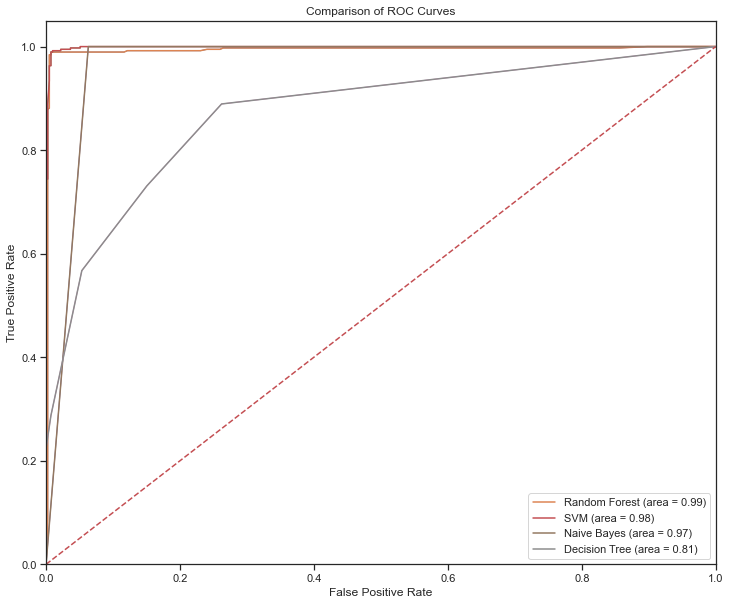

In [53]:
plt.figure(figsize=(12,10))
plt.plot(fpr_rf_b, tpr_rf_b, linewidth=1)
plt.plot(fpr_rf_b, tpr_rf_b, label='Random Forest (area = %0.2f)' % rf_roc_b)
plt.plot(fpr_svm_b, tpr_svm_b, linewidth=1)
plt.plot(fpr_svm_b, tpr_svm_b, label='SVM (area = %0.2f)' % svm_roc_b)
plt.plot(fpr_nb_b, tpr_nb_b, linewidth=1)
plt.plot(fpr_nb_b, tpr_nb_b, label='Naive Bayes (area = %0.2f)' % nb_roc_b)
plt.plot(fpr_dtree_b, tpr_dtree_b, linewidth=1)
plt.plot(fpr_dtree_b, tpr_dtree_b, label='Decision Tree (area = %0.2f)' % dtree_roc_b)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.rcParams['font.size'] = 10
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparison of ROC Curves')
plt.legend(loc="lower right")
plt.show()

Quello che possiamo notare è che i classifcaotri Random Forest e SVM sono quasi uguali, quindi affermiamo che essi, in questo caso, sono 
i migliori classificatori con un dataset bilanciato.